# **Classificação de Sentimentos**

## Importação e Instalação

In [65]:
import pandas as pd
import string
import spacy
import random
import seaborn as sns
import numpy as np

## Carregamento da Base de Dados

In [66]:
base_dados = pd.read_csv('/Users/gustavomeira/Documents/Python/Estudo_ML/projects/Processamento de Linguagem Natural/base_treinamento.txt', encoding='utf-8')
print(base_dados.shape)

(196, 2)


In [67]:
display(base_dados.head(5))

,texto,emocao
0,este trabalho é agradável,alegria
1,gosto de ficar no seu aconchego,alegria
2,fiz a adesão ao curso hoje,alegria
3,eu sou admirada por muitos,alegria
4,adoro como você,alegria


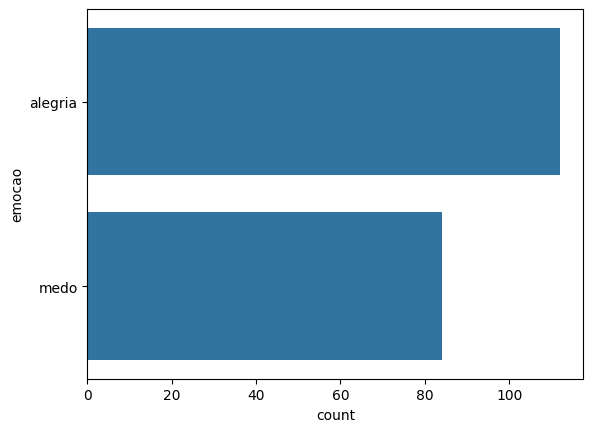

In [68]:
sns.countplot(base_dados['emocao'], label='Contagem');

## Pré-Processamento dos Textos

In [69]:
pontuacao = string.punctuation
print(pontuacao)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [70]:
from spacy.lang.pt.stop_words import STOP_WORDS

stop_words = STOP_WORDS

In [71]:
pln = spacy.load('pt_core_news_sm')

In [72]:
def preprocessamento(texto):
    # Recebimento de um texto sem letras maiúsculas
    texto = texto.lower()
    # Transformação do texto para variável spaCy
    documento = pln(texto)
    
    # Tokenização
    lista = []
    for token in documento:
        # Lemetização
        lista.append(token.lemma_)

    # Remoção de Stop Words e de Pontuações
    lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in pontuacao]
    lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
    
    return lista

In [73]:
base_dados['texto'] = base_dados['texto'].apply(preprocessamento)
display(base_dados.head())

base_dados_final = []
i = 0
for texto, emocao in zip(base_dados['texto'], base_dados['emocao']):
    # print(texto, emocao)
    if emocao == 'alegria':
        dic = ({'ALEGRIA':True, 'MEDO':False})
    elif emocao == 'medo':
        dic = ({'ALEGRIA':False, 'MEDO':True})

    base_dados_final.append([texto, dic.copy()])

print(base_dados_final[0])

,texto,emocao
0,trabalho agradável,alegria
1,gosto ficar em o aconchego,alegria
2,fiz adesão a o curso hoje,alegria
3,admirar,alegria
4,adorar,alegria


['trabalho agradável', {'ALEGRIA': True, 'MEDO': False}]


## Criação do Classificador

In [74]:
modelo = spacy.blank('pt')
categorias = modelo.add_pipe('textcat')
categorias.add_label('ALEGRIA')
categorias.add_label('MEDO')
# modelo.add_pipe(categorias)
historico = []

In [82]:
from spacy.training import Example

modelo.begin_training()

for epoca in range(1000):
    random.shuffle(base_dados_final)
    losses = {}
    examples = []
    
    for batch in spacy.util.minibatch(base_dados_final, 30):
        for texto, entities in batch:
            examples.append(Example.from_dict(modelo.make_doc(texto), {"cats": entities}))
        
    modelo.update(examples, losses=losses)
    
    if epoca % 100 == 0:
        print(losses)
        historico.append(losses)

{'textcat': 0.25}
{'textcat': 8.969954228173205e-14}
{'textcat': 6.940650989053013e-14}
{'textcat': 5.030848852197352e-14}
{'textcat': 3.612888593439341e-14}
{'textcat': 2.6273469551775334e-14}
{'textcat': 1.9679243518501248e-14}
{'textcat': 1.4543296512274477e-14}
{'textcat': 1.1245882798941158e-14}
{'textcat': 9.449837525714929e-15}


Text(0, 0.5, 'Erro')

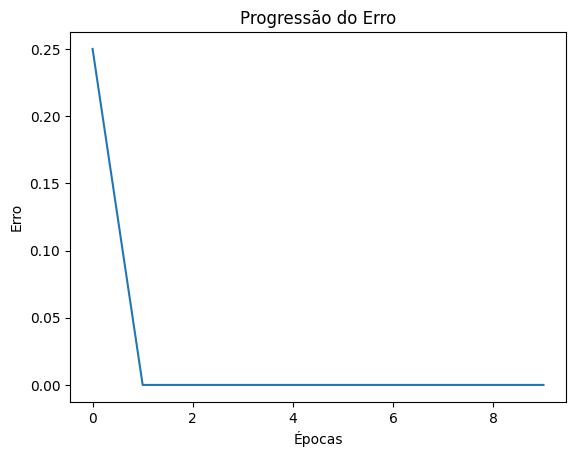

In [83]:
import matplotlib.pyplot as plt

historico_loss = []
for i in historico:
    historico_loss.append(i.get('textcat'))

historico_loss = np.array(historico_loss)

plt.plot(historico_loss)
plt.title('Progressão do Erro')
plt.xlabel('Épocas')
plt.ylabel('Erro')

In [84]:
modelo.to_disk('modelo')

## Teste com uma Frase

In [85]:
modelo_carregado = spacy.load('modelo')
modelo_carregado

In [90]:
texto_positivo = 'Eu amo meu namorado!'
texto_positivo = preprocessamento(texto_positivo)
previsao = modelo_carregado(texto_positivo)
print(previsao.cats)

{'ALEGRIA': 0.9999992847442627, 'MEDO': 6.957178015909449e-07}


In [89]:
texto_negativo = 'Estou com medo dele'
texto_negativo = preprocessamento(texto_negativo)
previsao = modelo_carregado(texto_negativo)
print(previsao.cats)

{'ALEGRIA': 4.3972512742129766e-08, 'MEDO': 1.0}


## Avaliação do Modelo

In [99]:
previsoes = []
for texto in base_dados['texto']:
    previsao = modelo_carregado(texto)
    previsoes.append(previsao.cats)

previsoes_final = []
for previsao in previsoes:
    if previsao['ALEGRIA'] > previsao['MEDO']:
        previsoes_final.append('alegria')
    else:
        previsoes_final.append('medo')
previsoes_final = np.array(previsoes_final)

In [101]:
from sklearn.metrics import confusion_matrix, accuracy_score

respostas_reais = base_dados['emocao'].values
display(accuracy_score(respostas_reais, previsoes_final))
display(confusion_matrix(respostas_reais, previsoes_final))

1.0

array([[112,   0],
       [  0,  84]])

In [102]:
base_dados_teste = pd.read_csv('/Users/gustavomeira/Documents/Python/Estudo_ML/projects/Processamento de Linguagem Natural/base_teste.txt', encoding='utf-8')
display(base_dados_teste.head())


,texto,emocao
0,não precisei pagar o ingresso,alegria
1,se eu ajeitar tudo fica bem,alegria
2,minha fortuna ultrapassará a sua,alegria
3,sou muito afortunado,alegria
4,é benéfico para todos esta nova medida,alegria


In [104]:
base_dados_teste['texto'] = base_dados_teste['texto'].apply(preprocessamento)

previsoes = []
for texto in base_dados_teste['texto']:
    previsao = modelo_carregado(texto)
    previsoes.append(previsao.cats)

previsoes_final = []
for previsao in previsoes:
    if previsao['ALEGRIA'] > previsao['MEDO']:
        previsoes_final.append('alegria')
    else:
        previsoes_final.append('medo')
previsoes_final = np.array(previsoes_final)

In [105]:
respostas_reais = base_dados_teste['emocao'].values
display(accuracy_score(respostas_reais, previsoes_final))
display(confusion_matrix(respostas_reais, previsoes_final))

0.5952380952380952

array([[32, 16],
       [18, 18]])